# Notebook2: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [63]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [64]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Plot Functions

In [65]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation and Feature Selection

In [66]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [ ]:
# Import data
trainset_df = pd.read_csv('Dataset1_train.csv')
testset_df = pd.read_csv('Dataset1_test.csv')

X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']



In [69]:
X_test

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z
0,3.0,6,0,8.0,12.4,9.0,10.9,26,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4.4,8,0,7.0,17.3,11.6,14.7,19,0,0,...,1,0,0,0,0,0,0,0,0,1
2,6.2,8,1,8.0,16.1,11.4,14.0,20,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5.3,8,1,6.0,14.6,10.3,12.7,22,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.0,6,1,5.0,14.3,11.9,13.2,21,0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,2.0,4,1,9.0,10.9,7.7,9.5,30,0,0,...,1,0,0,0,0,0,0,0,0,1
1473,2.0,4,1,6.0,12.6,9.7,11.3,25,0,0,...,0,1,0,0,0,0,0,0,1,0
1474,1.4,4,1,6.0,8.8,6.6,7.8,36,0,0,...,0,0,0,0,0,0,0,0,1,0
1475,3.5,6,1,7.0,11.9,8.2,10.2,28,0,0,...,0,0,0,0,0,0,0,0,0,1


### Setup pipline for Standardisation

In [ ]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [71]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [72]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0       -0.121493   0.205342      0.955277       -0.335091   
1        0.614166   0.205342     -1.589744        0.607277   
2       -0.121493   0.205342     -0.741404        0.350268   
3        0.172770   0.205342      0.106937       -0.363647   
4       -0.857153  -0.885139      0.955277       -0.706327   

   Fuel Consumption City (L/100 km)  Fuel Consumption Hwy (L/100 km)  \
0                         -0.429379                        -0.376817   
1                          0.564406                         0.592571   
2                         -0.022831                         0.246361   
3                         -0.519723                        -0.411438   
4                         -0.926271                        -0.792268   

   Fuel Consumption Comb (L/100 km)  Fuel Consumption Comb (mpg)  \
0                          0.217020                          0.0   
1                         -0.7562

In [73]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_Loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



## 3 Create Simple Neural Network

### 3.1 Define Neural Network Architecture

In [74]:
# Define the NN models
# Simple Neural Network, activate funcion - ReLU

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,output_size)
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.activation(hidden)
        out = self.fc2(hidden)
        return out

# Simple Neural Network, activate funcion - Tanh
class Simple_tanh_NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Simple_tanh_NN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size,output_size)
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.activation(hidden)
        out = self.fc2(hidden)
        return out

### 3.2 Train and Evaluate the NN model 

In [75]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



### Hold-out Validation for SimpleNeuralNetwork

#### Set Parameters

In [76]:
import torch.optim as optim

# Set  hyperparameters
input_size =  X_train_processed.shape[1]   # Input size 
hidden_size = 20            # Hiddern size
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Initialize the model
nn_model = SimpleNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
nn_model.to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)


#### Train and Validate

In [77]:
# Train & Evaluate the model
train_loss_hist = []
val_loss_hist = []

# Train the model
for epoch in range(n_epochs):  # n_epochs
    train_loss = train_epoch(nn_model, train_Loader, criterion, optimizer, device)
    val_loss = val_epoch(nn_model, val_Loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')

print("Training complete.")

Epoch 1/100, Train Loss: 31370.9969 | Validation Loss: 3049.5809
Epoch 2/100, Train Loss: 1600.3623 | Validation Loss: 1025.7220
Epoch 3/100, Train Loss: 856.3013 | Validation Loss: 778.0576
Epoch 4/100, Train Loss: 653.4870 | Validation Loss: 623.5726
Epoch 5/100, Train Loss: 512.6076 | Validation Loss: 509.7857
Epoch 6/100, Train Loss: 412.4296 | Validation Loss: 421.7235
Epoch 7/100, Train Loss: 341.4553 | Validation Loss: 356.7957
Epoch 8/100, Train Loss: 294.1226 | Validation Loss: 315.3878
Epoch 9/100, Train Loss: 257.9709 | Validation Loss: 278.6379
Epoch 10/100, Train Loss: 227.7501 | Validation Loss: 247.2473
Epoch 11/100, Train Loss: 201.3775 | Validation Loss: 216.9468
Epoch 12/100, Train Loss: 178.0617 | Validation Loss: 193.5300
Epoch 13/100, Train Loss: 156.6309 | Validation Loss: 165.4427
Epoch 14/100, Train Loss: 138.4535 | Validation Loss: 145.2094
Epoch 15/100, Train Loss: 120.4669 | Validation Loss: 123.4269
Epoch 16/100, Train Loss: 104.4919 | Validation Loss: 105.7

#### Evaluate Using Validation Loss and Visualization

Validation Loss: 19.0126


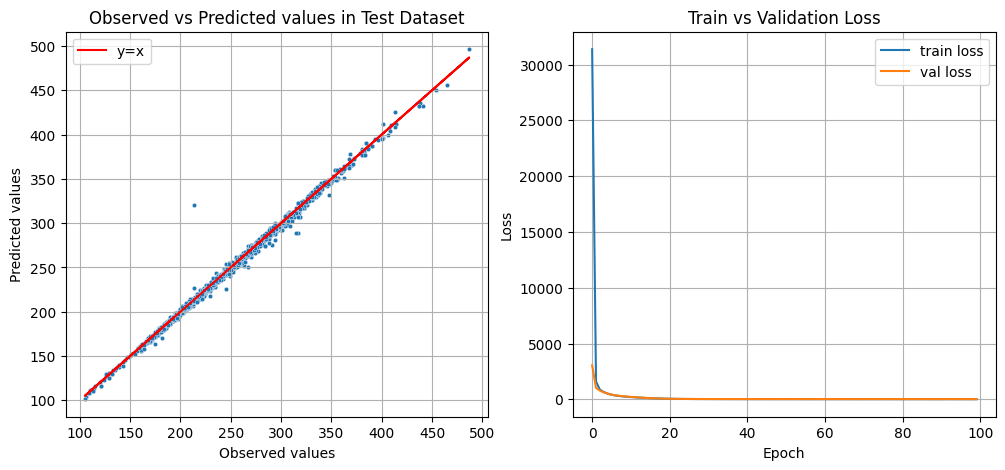

In [78]:
y_pred, y_label = model_prediction(nn_model, val_Loader, device)

# Evaluate model - Using Validation Loss-------------------
Val_loss = val_loss_hist[-1] # Use the last value of the validation loss as the final loss

print(f'Validation Loss: {Val_loss:.4f}')

# Evaluate model - Using plot--------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot of Observed and Predicted Values
plot_pred_true(y_label, y_pred, ax[0])      

# Plot of Loss values & Epoch
plot_train_val_loss(train_loss_hist, val_loss_hist, ax[1])


### K-fold Cross-Validation

In [79]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Define the two model architectures using lambdas to easily reinitialize per fold
models = {
    "Small Single Model": lambda: SimpleNeuralNetwork(input_size=input_size, hidden_size=16, output_size=1),
    "Large Single Model": lambda: SimpleNeuralNetwork(input_size=input_size, hidden_size=32, output_size=1),
    "Small S_tanh Model": lambda: Simple_tanh_NN(input_size=input_size, hidden_size=16, output_size=1),
    "Large S_tanh Model": lambda: Simple_tanh_NN(input_size=input_size, hidden_size=32, output_size=1)
}

# Set hyperparameters
k_folds = 5         # k=5 fold
num_epochs = 20     # Number of epochs per fold

# Set up K-Fold Cross Validation (K=5)
kfold = KFold(n_splits=k_folds, shuffle=True)

for model_name, model_fn in models.items():
    print(f"Cross Validation for {model_name}")
    
    fold_train_losses = []
    fold_val_losses = []
    fold_number = 1
    
    for train_idx, val_idx in kfold.split(range(len(train_dataset))):     # Generate the idex of training and testing dataset # len(train_dataset) # 5908 
        # print(f"Fold {fold_number}")
        # Create subsets for training and validation data for this fold
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        
        trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=64, shuffle=False)
        
        # Initialize model, loss function, and optimizer for this fold
        model = model_fn().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        
        # Train for the specified number of epochs and evaluate after each epoch
        for epoch in range(num_epochs):
            train_loss = train_epoch(model, trainloader, criterion, optimizer, device)
            val_loss = val_epoch(model, valloader, criterion, device)
            # print(f" Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        
        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_number += 1
        
    overall_train_loss = sum(fold_train_losses) / k_folds
    overall_val_loss = sum(fold_val_losses) / k_folds
    print(f"Overall {model_name} - Train Loss: {overall_train_loss:.4f} | Validation Loss: {overall_val_loss:.4f}")

print("Cross-validation complete.")


Cross Validation for Small Single Model
Overall Small Single Model - Train Loss: 39.4367 | Validation Loss: 32.2452
Cross Validation for Large Single Model
Overall Large Single Model - Train Loss: 42.4672 | Validation Loss: 25.3715
Cross Validation for Small S_tanh Model
Overall Small S_tanh Model - Train Loss: 83.5136 | Validation Loss: 91.9788
Cross Validation for Large S_tanh Model
Overall Large S_tanh Model - Train Loss: 42.5891 | Validation Loss: 53.6551
Cross-validation complete.


#### Set and Train the Model

Select the best model in the K-fold validation, which is the model with activate function tanh, hidden layer size = 32.

In [80]:
# Initialize the model
sth_nn_model = Simple_tanh_NN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
sth_nn_model.to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression
optimizer = optim.Adam(sth_nn_model.parameters(), lr=0.02)

# Train & Evaluate the model
train_loss_hist = []
val_loss_hist = []
n_epochs = 100

# Train the model
for epoch in range(n_epochs):  # n_epochs
    train_loss = train_epoch(sth_nn_model, train_Loader, criterion, optimizer, device)
    val_loss = val_epoch(sth_nn_model, val_Loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')

print("Training complete.")


Epoch 1/100, Train Loss: 56616.0330 | Validation Loss: 45920.0199
Epoch 2/100, Train Loss: 39254.1379 | Validation Loss: 31901.0747
Epoch 3/100, Train Loss: 27281.0727 | Validation Loss: 21995.5223
Epoch 4/100, Train Loss: 18829.9049 | Validation Loss: 15117.8448
Epoch 5/100, Train Loss: 12991.8331 | Validation Loss: 10450.9249
Epoch 6/100, Train Loss: 9111.7307 | Validation Loss: 7453.6277
Epoch 7/100, Train Loss: 6630.2953 | Validation Loss: 5438.1514
Epoch 8/100, Train Loss: 4829.8047 | Validation Loss: 4016.3312
Epoch 9/100, Train Loss: 3625.9498 | Validation Loss: 3075.4539
Epoch 10/100, Train Loss: 2808.4901 | Validation Loss: 2430.7093
Epoch 11/100, Train Loss: 2244.5930 | Validation Loss: 1983.4567
Epoch 12/100, Train Loss: 1835.4781 | Validation Loss: 1612.2286
Epoch 13/100, Train Loss: 1500.2962 | Validation Loss: 1349.8069
Epoch 14/100, Train Loss: 1261.9286 | Validation Loss: 1151.0585
Epoch 15/100, Train Loss: 1085.9487 | Validation Loss: 1003.8110
Epoch 16/100, Train Loss

#### Using Validation Loss and Visualization to evaluate

Validation Loss: 23.6829


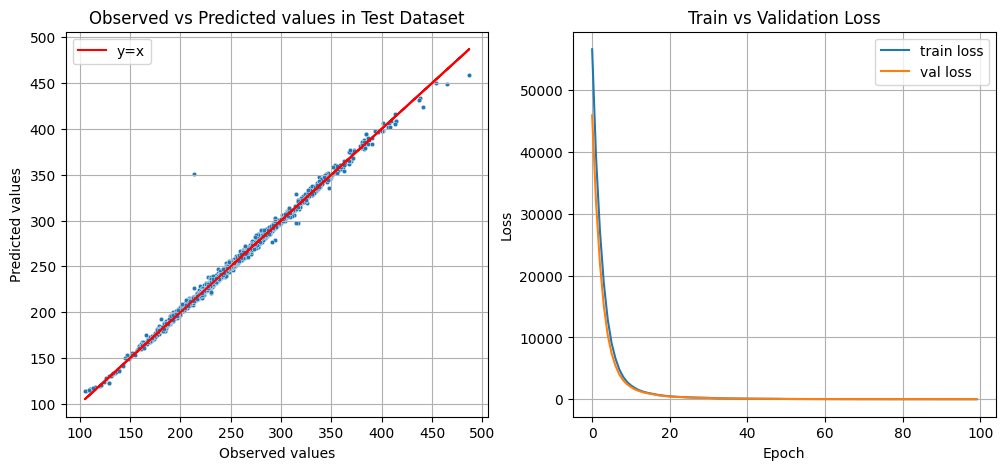

In [81]:
y_pred, y_label = model_prediction(sth_nn_model, val_Loader, device)

# Evaluate model - Using Validation Loss-------------------
Val_loss = val_loss_hist[-1] # Use the last value of the validation loss as the final loss

print(f'Validation Loss: {Val_loss:.4f}')

# Evaluate model - Using plot--------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot of Observed and Predicted Values
plot_pred_true(y_label, y_pred, ax[0])      

# Plot of Loss values & Epoch
plot_train_val_loss(train_loss_hist, val_loss_hist, ax[1])

## 4 Using W&B

In [82]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\87383\_netrc


True

In [83]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [84]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [85]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience


In [86]:
from itertools import product

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork G4', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        val_loss = val_epoch(model, val_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: 5755.1667 | Val Loss: 475.3046
Epoch 002 | Train Loss: 296.1576 | Val Loss: 214.3189
Epoch 003 | Train Loss: 169.7315 | Val Loss: 158.8454
Epoch 004 | Train Loss: 84.7168 | Val Loss: 75.6446
Epoch 005 | Train Loss: 46.4241 | Val Loss: 80.8806
Epoch 006 | Train Loss: 38.9939 | Val Loss: 21.4513
Epoch 007 | Train Loss: 37.7788 | Val Loss: 88.3731
Epoch 008 | Train Loss: 28.0677 | Val Loss: 16.8753
Epoch 009 | Train Loss: 19.0801 | Val Loss: 90.1482
Epoch 010 | Train Loss: 39.4213 | Val Loss: 33.4028
Epoch 011 | Train Loss: 50.3325 | Val Loss: 41.3445
Epoch 012 | Train Loss: 48.2155 | Val Loss: 54.5857
Epoch 013 | Train Loss: 45.8562 | Val Loss: 176.6494
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▂▁▂▁▁▂▃
epoch,13
train_loss,45.85624
val_loss,176.64945


Epoch 001 | Train Loss: 25727.6832 | Val Loss: 1438.1609
Epoch 002 | Train Loss: 905.1476 | Val Loss: 687.0062
Epoch 003 | Train Loss: 523.0031 | Val Loss: 449.0701
Epoch 004 | Train Loss: 335.9465 | Val Loss: 326.3245
Epoch 005 | Train Loss: 245.6130 | Val Loss: 250.8901
Epoch 006 | Train Loss: 194.1621 | Val Loss: 201.3530
Epoch 007 | Train Loss: 158.9533 | Val Loss: 161.8649
Epoch 008 | Train Loss: 132.1753 | Val Loss: 141.2452
Epoch 009 | Train Loss: 108.2684 | Val Loss: 111.1743
Epoch 010 | Train Loss: 89.5339 | Val Loss: 90.5126
Epoch 011 | Train Loss: 69.4916 | Val Loss: 68.4712
Epoch 012 | Train Loss: 54.2281 | Val Loss: 54.3191
Epoch 013 | Train Loss: 44.1602 | Val Loss: 44.9049
Epoch 014 | Train Loss: 36.6070 | Val Loss: 43.4298
Epoch 015 | Train Loss: 32.1585 | Val Loss: 31.0291
Epoch 016 | Train Loss: 27.1528 | Val Loss: 26.5661
Epoch 017 | Train Loss: 24.7425 | Val Loss: 25.5465
Epoch 018 | Train Loss: 22.5369 | Val Loss: 22.1124
Epoch 019 | Train Loss: 21.4854 | Val Loss:

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,37
train_loss,11.46327
val_loss,11.734


Epoch 001 | Train Loss: 65440.1877 | Val Loss: 60751.5998
Epoch 002 | Train Loss: 50908.1185 | Val Loss: 32829.1198
Epoch 003 | Train Loss: 16810.6464 | Val Loss: 5734.5379
Epoch 004 | Train Loss: 3648.9196 | Val Loss: 2770.2766
Epoch 005 | Train Loss: 2194.3257 | Val Loss: 1861.3722
Epoch 006 | Train Loss: 1530.9390 | Val Loss: 1381.0566
Epoch 007 | Train Loss: 1181.5073 | Val Loss: 1119.4762
Epoch 008 | Train Loss: 987.7287 | Val Loss: 972.4165
Epoch 009 | Train Loss: 870.8102 | Val Loss: 874.8122
Epoch 010 | Train Loss: 790.2271 | Val Loss: 803.9286
Epoch 011 | Train Loss: 726.5494 | Val Loss: 747.1788
Epoch 012 | Train Loss: 673.6937 | Val Loss: 697.6532
Epoch 013 | Train Loss: 626.8244 | Val Loss: 656.2189
Epoch 014 | Train Loss: 585.7708 | Val Loss: 622.0438
Epoch 015 | Train Loss: 548.8191 | Val Loss: 583.6665
Epoch 016 | Train Loss: 516.4083 | Val Loss: 552.1851
Epoch 017 | Train Loss: 485.3021 | Val Loss: 522.7752
Epoch 018 | Train Loss: 456.9394 | Val Loss: 497.8522
Epoch 019

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇███
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,132
train_loss,9.92948
val_loss,10.29714


Epoch 001 | Train Loss: 5099.9332 | Val Loss: 417.4772
Epoch 002 | Train Loss: 245.7234 | Val Loss: 310.0649
Epoch 003 | Train Loss: 159.3754 | Val Loss: 136.9104
Epoch 004 | Train Loss: 74.1295 | Val Loss: 64.3673
Epoch 005 | Train Loss: 55.9809 | Val Loss: 63.0909
Epoch 006 | Train Loss: 31.1754 | Val Loss: 25.7921
Epoch 007 | Train Loss: 44.9315 | Val Loss: 131.1459
Epoch 008 | Train Loss: 34.7636 | Val Loss: 26.0216
Epoch 009 | Train Loss: 27.9119 | Val Loss: 23.5582
Epoch 010 | Train Loss: 26.5405 | Val Loss: 45.4283
Epoch 011 | Train Loss: 82.7113 | Val Loss: 227.5278
Epoch 012 | Train Loss: 83.8171 | Val Loss: 391.9054
Epoch 013 | Train Loss: 80.1995 | Val Loss: 161.0709
Epoch 014 | Train Loss: 123.5877 | Val Loss: 160.2784
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▁▃▁▁▁▅█▃▃
epoch,14
train_loss,123.58768
val_loss,160.27842


Epoch 001 | Train Loss: 18149.8210 | Val Loss: 804.0435
Epoch 002 | Train Loss: 552.4987 | Val Loss: 444.9446
Epoch 003 | Train Loss: 341.4959 | Val Loss: 317.2649
Epoch 004 | Train Loss: 242.1503 | Val Loss: 224.0320
Epoch 005 | Train Loss: 182.2580 | Val Loss: 169.2749
Epoch 006 | Train Loss: 134.5874 | Val Loss: 126.4938
Epoch 007 | Train Loss: 98.8484 | Val Loss: 83.2489
Epoch 008 | Train Loss: 64.8457 | Val Loss: 56.8177
Epoch 009 | Train Loss: 48.6123 | Val Loss: 42.7301
Epoch 010 | Train Loss: 35.1056 | Val Loss: 30.3605
Epoch 011 | Train Loss: 29.4985 | Val Loss: 33.0009
Epoch 012 | Train Loss: 27.2567 | Val Loss: 21.9548
Epoch 013 | Train Loss: 21.6909 | Val Loss: 19.9651
Epoch 014 | Train Loss: 19.5781 | Val Loss: 17.9410
Epoch 015 | Train Loss: 17.7037 | Val Loss: 21.7990
Epoch 016 | Train Loss: 18.5354 | Val Loss: 18.4289
Epoch 017 | Train Loss: 16.9022 | Val Loss: 14.2847
Epoch 018 | Train Loss: 16.5368 | Val Loss: 13.3478
Epoch 019 | Train Loss: 15.0018 | Val Loss: 21.419

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,16.57125
val_loss,24.88373


Epoch 001 | Train Loss: 65041.7668 | Val Loss: 56896.2493
Epoch 002 | Train Loss: 26428.3938 | Val Loss: 4294.6462
Epoch 003 | Train Loss: 2658.5773 | Val Loss: 1810.6785
Epoch 004 | Train Loss: 1335.8724 | Val Loss: 1127.0448
Epoch 005 | Train Loss: 926.4436 | Val Loss: 883.8576
Epoch 006 | Train Loss: 747.5397 | Val Loss: 733.0386
Epoch 007 | Train Loss: 629.1078 | Val Loss: 629.1309
Epoch 008 | Train Loss: 540.2475 | Val Loss: 551.8532
Epoch 009 | Train Loss: 465.1961 | Val Loss: 483.1121
Epoch 010 | Train Loss: 405.0144 | Val Loss: 428.9437
Epoch 011 | Train Loss: 354.4956 | Val Loss: 383.2632
Epoch 012 | Train Loss: 312.6279 | Val Loss: 342.7978
Epoch 013 | Train Loss: 278.3395 | Val Loss: 304.6086
Epoch 014 | Train Loss: 249.0451 | Val Loss: 274.1144
Epoch 015 | Train Loss: 221.4235 | Val Loss: 252.4464
Epoch 016 | Train Loss: 199.0024 | Val Loss: 220.7181
Epoch 017 | Train Loss: 178.1425 | Val Loss: 196.4282
Epoch 018 | Train Loss: 159.6451 | Val Loss: 175.3473
Epoch 019 | Train

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
train_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,77
train_loss,11.0634
val_loss,13.36732


Epoch 001 | Train Loss: 4150.7476 | Val Loss: 423.9538
Epoch 002 | Train Loss: 225.5042 | Val Loss: 145.6901
Epoch 003 | Train Loss: 96.2538 | Val Loss: 117.2358
Epoch 004 | Train Loss: 90.7955 | Val Loss: 470.0978
Epoch 005 | Train Loss: 158.6285 | Val Loss: 35.6425
Epoch 006 | Train Loss: 32.2538 | Val Loss: 433.4558
Epoch 007 | Train Loss: 109.2767 | Val Loss: 55.1308
Epoch 008 | Train Loss: 36.0930 | Val Loss: 16.1150
Epoch 009 | Train Loss: 115.9659 | Val Loss: 93.9150
Epoch 010 | Train Loss: 3320.7165 | Val Loss: 666.1261
Epoch 011 | Train Loss: 216.2241 | Val Loss: 114.6888
Epoch 012 | Train Loss: 81.4851 | Val Loss: 54.6069
Epoch 013 | Train Loss: 52.3151 | Val Loss: 69.9829
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▇▁▁▁
val_loss,▅▂▂▆▁▅▁▁▂█▂▁▂
epoch,13
train_loss,52.31512
val_loss,69.9829


Epoch 001 | Train Loss: 14568.2336 | Val Loss: 749.4435
Epoch 002 | Train Loss: 513.4824 | Val Loss: 387.8628
Epoch 003 | Train Loss: 286.6382 | Val Loss: 275.4873
Epoch 004 | Train Loss: 209.3208 | Val Loss: 189.8021
Epoch 005 | Train Loss: 151.8311 | Val Loss: 156.2719
Epoch 006 | Train Loss: 116.3945 | Val Loss: 102.0252
Epoch 007 | Train Loss: 76.2231 | Val Loss: 73.6797
Epoch 008 | Train Loss: 51.0695 | Val Loss: 54.4226
Epoch 009 | Train Loss: 35.4196 | Val Loss: 32.8411
Epoch 010 | Train Loss: 27.7807 | Val Loss: 23.1437
Epoch 011 | Train Loss: 25.1354 | Val Loss: 34.5469
Epoch 012 | Train Loss: 20.8793 | Val Loss: 16.8985
Epoch 013 | Train Loss: 18.2827 | Val Loss: 16.4794
Epoch 014 | Train Loss: 16.0925 | Val Loss: 19.0434
Epoch 015 | Train Loss: 15.5031 | Val Loss: 14.2710
Epoch 016 | Train Loss: 15.4355 | Val Loss: 14.8407
Epoch 017 | Train Loss: 14.9453 | Val Loss: 14.1000
Epoch 018 | Train Loss: 15.7153 | Val Loss: 23.6058
Epoch 019 | Train Loss: 16.0551 | Val Loss: 15.465

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
train_loss,12.24437
val_loss,11.76949


Epoch 001 | Train Loss: 63465.4923 | Val Loss: 43988.8035
Epoch 002 | Train Loss: 10333.7793 | Val Loss: 2234.3794
Epoch 003 | Train Loss: 1504.1220 | Val Loss: 1119.9754
Epoch 004 | Train Loss: 888.9924 | Val Loss: 773.4976
Epoch 005 | Train Loss: 658.7300 | Val Loss: 610.1914
Epoch 006 | Train Loss: 521.2367 | Val Loss: 502.7043
Epoch 007 | Train Loss: 430.0104 | Val Loss: 425.7953
Epoch 008 | Train Loss: 363.1494 | Val Loss: 373.3463
Epoch 009 | Train Loss: 316.5484 | Val Loss: 328.0149
Epoch 010 | Train Loss: 280.0814 | Val Loss: 295.5734
Epoch 011 | Train Loss: 251.9353 | Val Loss: 267.7888
Epoch 012 | Train Loss: 230.0275 | Val Loss: 242.7524
Epoch 013 | Train Loss: 209.5102 | Val Loss: 224.9370
Epoch 014 | Train Loss: 192.5945 | Val Loss: 202.8320
Epoch 015 | Train Loss: 175.3031 | Val Loss: 184.4434
Epoch 016 | Train Loss: 161.0177 | Val Loss: 167.2969
Epoch 017 | Train Loss: 149.2015 | Val Loss: 152.3935
Epoch 018 | Train Loss: 135.2023 | Val Loss: 138.9132
Epoch 019 | Train L

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,66
train_loss,9.9581
val_loss,14.53296


Epoch 001 | Train Loss: 4159.5333 | Val Loss: 326.0117
Epoch 002 | Train Loss: 244.6358 | Val Loss: 191.6026
Epoch 003 | Train Loss: 122.3177 | Val Loss: 58.7128
Epoch 004 | Train Loss: 48.6403 | Val Loss: 63.6457
Epoch 005 | Train Loss: 50.0521 | Val Loss: 58.0092
Epoch 006 | Train Loss: 50.5816 | Val Loss: 92.6127
Epoch 007 | Train Loss: 76.5453 | Val Loss: 56.3411
Epoch 008 | Train Loss: 49.9257 | Val Loss: 36.6017
Epoch 009 | Train Loss: 46.2590 | Val Loss: 66.1668
Epoch 010 | Train Loss: 72.7361 | Val Loss: 171.0668
Epoch 011 | Train Loss: 133.3160 | Val Loss: 22.0113
Epoch 012 | Train Loss: 38.4230 | Val Loss: 164.1436
Epoch 013 | Train Loss: 28.1293 | Val Loss: 22.7397
Epoch 014 | Train Loss: 65.7328 | Val Loss: 277.8694
Epoch 015 | Train Loss: 68.8774 | Val Loss: 58.5315
Epoch 016 | Train Loss: 37.9511 | Val Loss: 29.9240
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▃▂▁▂▄▁▄▁▇▂▁
epoch,16
train_loss,37.95112
val_loss,29.92397


Epoch 001 | Train Loss: 16806.3476 | Val Loss: 844.8270
Epoch 002 | Train Loss: 597.2754 | Val Loss: 497.0017
Epoch 003 | Train Loss: 369.7763 | Val Loss: 356.7122
Epoch 004 | Train Loss: 271.3100 | Val Loss: 271.9874
Epoch 005 | Train Loss: 208.8713 | Val Loss: 209.1034
Epoch 006 | Train Loss: 161.7576 | Val Loss: 157.4304
Epoch 007 | Train Loss: 124.5126 | Val Loss: 122.2102
Epoch 008 | Train Loss: 91.7082 | Val Loss: 82.8831
Epoch 009 | Train Loss: 64.5151 | Val Loss: 61.5794
Epoch 010 | Train Loss: 47.1956 | Val Loss: 46.6039
Epoch 011 | Train Loss: 34.6103 | Val Loss: 32.7009
Epoch 012 | Train Loss: 28.8246 | Val Loss: 26.7159
Epoch 013 | Train Loss: 24.0553 | Val Loss: 23.0614
Epoch 014 | Train Loss: 21.4303 | Val Loss: 19.5845
Epoch 015 | Train Loss: 20.0849 | Val Loss: 23.7976
Epoch 016 | Train Loss: 19.5478 | Val Loss: 24.4100
Epoch 017 | Train Loss: 18.8466 | Val Loss: 14.8416
Epoch 018 | Train Loss: 16.3573 | Val Loss: 21.3700
Epoch 019 | Train Loss: 17.3817 | Val Loss: 16.5

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,35
train_loss,11.48582
val_loss,14.79355


Epoch 001 | Train Loss: 63531.6999 | Val Loss: 52989.2961
Epoch 002 | Train Loss: 29485.8449 | Val Loss: 7804.5818
Epoch 003 | Train Loss: 4237.4414 | Val Loss: 2815.6782
Epoch 004 | Train Loss: 1985.0144 | Val Loss: 1609.4894
Epoch 005 | Train Loss: 1270.7559 | Val Loss: 1150.8603
Epoch 006 | Train Loss: 983.3341 | Val Loss: 947.0905
Epoch 007 | Train Loss: 836.0015 | Val Loss: 824.6728
Epoch 008 | Train Loss: 743.1459 | Val Loss: 744.6441
Epoch 009 | Train Loss: 670.5056 | Val Loss: 682.4151
Epoch 010 | Train Loss: 609.8387 | Val Loss: 626.6578
Epoch 011 | Train Loss: 556.5514 | Val Loss: 579.4258
Epoch 012 | Train Loss: 511.0463 | Val Loss: 534.5595
Epoch 013 | Train Loss: 470.7794 | Val Loss: 496.5877
Epoch 014 | Train Loss: 434.9398 | Val Loss: 462.7176
Epoch 015 | Train Loss: 403.7638 | Val Loss: 434.5674
Epoch 016 | Train Loss: 376.1617 | Val Loss: 404.8803
Epoch 017 | Train Loss: 351.5209 | Val Loss: 381.5610
Epoch 018 | Train Loss: 329.6340 | Val Loss: 361.7249
Epoch 019 | Tra

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▄▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,119
train_loss,8.82345
val_loss,8.60048


Epoch 001 | Train Loss: 4013.3878 | Val Loss: 339.3529
Epoch 002 | Train Loss: 272.7142 | Val Loss: 192.3919
Epoch 003 | Train Loss: 133.1508 | Val Loss: 68.4257
Epoch 004 | Train Loss: 124.4393 | Val Loss: 42.9526
Epoch 005 | Train Loss: 107.1195 | Val Loss: 46.8622
Epoch 006 | Train Loss: 140.6895 | Val Loss: 955.2951
Epoch 007 | Train Loss: 1082.2223 | Val Loss: 107.7919
Epoch 008 | Train Loss: 46.5713 | Val Loss: 27.2504
Epoch 009 | Train Loss: 28.3408 | Val Loss: 22.0557
Epoch 010 | Train Loss: 20.1166 | Val Loss: 23.1794
Epoch 011 | Train Loss: 27.4638 | Val Loss: 43.0200
Epoch 012 | Train Loss: 27.0630 | Val Loss: 59.5567
Epoch 013 | Train Loss: 37.3398 | Val Loss: 21.2830
Epoch 014 | Train Loss: 39.6811 | Val Loss: 40.5471
Epoch 015 | Train Loss: 34.7090 | Val Loss: 36.0053
Epoch 016 | Train Loss: 107.4258 | Val Loss: 226.5948
Epoch 017 | Train Loss: 126.6880 | Val Loss: 18.3895
Epoch 018 | Train Loss: 53.1740 | Val Loss: 38.4104
Epoch 019 | Train Loss: 73.2187 | Val Loss: 17.7

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▁▁▁█▂▁▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,33
train_loss,23.98026
val_loss,26.25729


Epoch 001 | Train Loss: 11765.6220 | Val Loss: 590.4697
Epoch 002 | Train Loss: 370.2418 | Val Loss: 313.3015
Epoch 003 | Train Loss: 226.8872 | Val Loss: 215.6715
Epoch 004 | Train Loss: 163.6159 | Val Loss: 141.1259
Epoch 005 | Train Loss: 103.7665 | Val Loss: 82.8504
Epoch 006 | Train Loss: 62.8238 | Val Loss: 61.7177
Epoch 007 | Train Loss: 41.1540 | Val Loss: 49.9533
Epoch 008 | Train Loss: 36.9434 | Val Loss: 28.2494
Epoch 009 | Train Loss: 24.7202 | Val Loss: 30.3270
Epoch 010 | Train Loss: 22.5126 | Val Loss: 19.1938
Epoch 011 | Train Loss: 20.5580 | Val Loss: 16.3141
Epoch 012 | Train Loss: 17.4784 | Val Loss: 21.0191
Epoch 013 | Train Loss: 18.1400 | Val Loss: 13.1887
Epoch 014 | Train Loss: 17.6562 | Val Loss: 17.7515
Epoch 015 | Train Loss: 16.3177 | Val Loss: 18.7904
Epoch 016 | Train Loss: 20.5482 | Val Loss: 14.5842
Epoch 017 | Train Loss: 15.4009 | Val Loss: 16.1844
Epoch 018 | Train Loss: 15.8837 | Val Loss: 32.4994
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,18
train_loss,15.88365
val_loss,32.49935


Epoch 001 | Train Loss: 57824.3685 | Val Loss: 21195.8467
Epoch 002 | Train Loss: 5213.3907 | Val Loss: 2061.6527
Epoch 003 | Train Loss: 1325.5234 | Val Loss: 1006.1215
Epoch 004 | Train Loss: 812.0498 | Val Loss: 728.8470
Epoch 005 | Train Loss: 622.3067 | Val Loss: 595.0953
Epoch 006 | Train Loss: 505.7649 | Val Loss: 496.7093
Epoch 007 | Train Loss: 424.9513 | Val Loss: 429.8438
Epoch 008 | Train Loss: 362.5624 | Val Loss: 373.3750
Epoch 009 | Train Loss: 316.9835 | Val Loss: 336.1019
Epoch 010 | Train Loss: 280.6810 | Val Loss: 302.5887
Epoch 011 | Train Loss: 252.8434 | Val Loss: 264.4995
Epoch 012 | Train Loss: 225.8199 | Val Loss: 235.5130
Epoch 013 | Train Loss: 203.5511 | Val Loss: 216.0209
Epoch 014 | Train Loss: 183.2006 | Val Loss: 185.7576
Epoch 015 | Train Loss: 163.8093 | Val Loss: 166.7886
Epoch 016 | Train Loss: 145.5758 | Val Loss: 145.0903
Epoch 017 | Train Loss: 127.3354 | Val Loss: 127.3306
Epoch 018 | Train Loss: 111.9528 | Val Loss: 115.7298
Epoch 019 | Train Lo

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,74
train_loss,10.58722
val_loss,12.51107


Epoch 001 | Train Loss: 22593.0815 | Val Loss: 682.0289
Epoch 002 | Train Loss: 495.5683 | Val Loss: 359.0798
Epoch 003 | Train Loss: 240.3910 | Val Loss: 171.9528
Epoch 004 | Train Loss: 174.1558 | Val Loss: 478.4596
Epoch 005 | Train Loss: 284.7962 | Val Loss: 224.9861
Epoch 006 | Train Loss: 158.6267 | Val Loss: 751.6557
Epoch 007 | Train Loss: 230.6269 | Val Loss: 128.2203
Epoch 008 | Train Loss: 96.9380 | Val Loss: 52.8222
Epoch 009 | Train Loss: 70.4091 | Val Loss: 84.5092
Epoch 010 | Train Loss: 71.9085 | Val Loss: 207.6078
Epoch 011 | Train Loss: 142.5457 | Val Loss: 42.0048
Epoch 012 | Train Loss: 42.5822 | Val Loss: 47.7823
Epoch 013 | Train Loss: 74.4651 | Val Loss: 60.8459
Epoch 014 | Train Loss: 46.6313 | Val Loss: 400.4543
Epoch 015 | Train Loss: 65.9219 | Val Loss: 41.4847
Epoch 016 | Train Loss: 45.4087 | Val Loss: 32.8495
Epoch 017 | Train Loss: 43.0065 | Val Loss: 245.7033
Epoch 018 | Train Loss: 105.8988 | Val Loss: 296.9592
Epoch 019 | Train Loss: 3953.1098 | Val Lo

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▃▅▃█▂▁▂▃▁▁▁▅▁▁▃▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,15.35213
val_loss,14.72122


Epoch 001 | Train Loss: 9763.2508 | Val Loss: 436.0948
Epoch 002 | Train Loss: 289.5379 | Val Loss: 232.7423
Epoch 003 | Train Loss: 172.3680 | Val Loss: 149.3391
Epoch 004 | Train Loss: 113.4185 | Val Loss: 88.3863
Epoch 005 | Train Loss: 67.9341 | Val Loss: 50.5100
Epoch 006 | Train Loss: 39.1254 | Val Loss: 59.8055
Epoch 007 | Train Loss: 34.8625 | Val Loss: 47.4802
Epoch 008 | Train Loss: 29.9730 | Val Loss: 26.0933
Epoch 009 | Train Loss: 20.3136 | Val Loss: 21.1052
Epoch 010 | Train Loss: 28.0883 | Val Loss: 16.9439
Epoch 011 | Train Loss: 18.2314 | Val Loss: 40.6415
Epoch 012 | Train Loss: 39.5072 | Val Loss: 66.0950
Epoch 013 | Train Loss: 29.2500 | Val Loss: 15.1899
Epoch 014 | Train Loss: 20.6972 | Val Loss: 29.5931
Epoch 015 | Train Loss: 23.5441 | Val Loss: 13.2849
Epoch 016 | Train Loss: 17.0177 | Val Loss: 28.0947
Epoch 017 | Train Loss: 17.6925 | Val Loss: 11.7147
Epoch 018 | Train Loss: 17.3237 | Val Loss: 11.6806
Epoch 019 | Train Loss: 19.0024 | Val Loss: 20.3321
Epoc

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
epoch,23
train_loss,20.09134
val_loss,59.658


Epoch 001 | Train Loss: 49111.3818 | Val Loss: 7266.3776
Epoch 002 | Train Loss: 2418.8860 | Val Loss: 1096.5771
Epoch 003 | Train Loss: 753.3475 | Val Loss: 610.3975
Epoch 004 | Train Loss: 481.0101 | Val Loss: 439.8553
Epoch 005 | Train Loss: 358.4765 | Val Loss: 350.2346
Epoch 006 | Train Loss: 286.3678 | Val Loss: 298.4692
Epoch 007 | Train Loss: 239.3473 | Val Loss: 245.7331
Epoch 008 | Train Loss: 202.2340 | Val Loss: 211.3087
Epoch 009 | Train Loss: 174.8704 | Val Loss: 184.0883
Epoch 010 | Train Loss: 154.6795 | Val Loss: 164.0100
Epoch 011 | Train Loss: 135.5188 | Val Loss: 144.6194
Epoch 012 | Train Loss: 122.9163 | Val Loss: 128.8802
Epoch 013 | Train Loss: 107.8692 | Val Loss: 111.7712
Epoch 014 | Train Loss: 95.2278 | Val Loss: 99.5646
Epoch 015 | Train Loss: 84.5868 | Val Loss: 88.5890
Epoch 016 | Train Loss: 74.4023 | Val Loss: 77.3058
Epoch 017 | Train Loss: 65.4114 | Val Loss: 66.9114
Epoch 018 | Train Loss: 56.8302 | Val Loss: 58.9734
Epoch 019 | Train Loss: 51.1640 |

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,48
train_loss,12.0892
val_loss,24.87945


Epoch 001 | Train Loss: 12227.6263 | Val Loss: 499.7431
Epoch 002 | Train Loss: 322.2107 | Val Loss: 278.8039
Epoch 003 | Train Loss: 169.4481 | Val Loss: 150.2505
Epoch 004 | Train Loss: 69.3991 | Val Loss: 40.5596
Epoch 005 | Train Loss: 38.0722 | Val Loss: 48.4696
Epoch 006 | Train Loss: 34.2081 | Val Loss: 29.6376
Epoch 007 | Train Loss: 29.4689 | Val Loss: 24.5691
Epoch 008 | Train Loss: 26.1999 | Val Loss: 30.7175
Epoch 009 | Train Loss: 36.7946 | Val Loss: 34.0902
Epoch 010 | Train Loss: 27.4697 | Val Loss: 43.4406
Epoch 011 | Train Loss: 33.1243 | Val Loss: 320.6629
Epoch 012 | Train Loss: 65.4011 | Val Loss: 48.4197
Early stopping triggered at epoch 12


epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▁▁▁▁▁▅▁
epoch,12
train_loss,65.40114
val_loss,48.41966


Epoch 001 | Train Loss: 12224.9449 | Val Loss: 692.4849
Epoch 002 | Train Loss: 488.2334 | Val Loss: 409.3462
Epoch 003 | Train Loss: 304.6133 | Val Loss: 283.4939
Epoch 004 | Train Loss: 216.6339 | Val Loss: 200.8066
Epoch 005 | Train Loss: 160.5215 | Val Loss: 152.1879
Epoch 006 | Train Loss: 115.7467 | Val Loss: 121.2122
Epoch 007 | Train Loss: 78.2552 | Val Loss: 68.4942
Epoch 008 | Train Loss: 52.5021 | Val Loss: 46.4135
Epoch 009 | Train Loss: 38.7241 | Val Loss: 31.9834
Epoch 010 | Train Loss: 28.5940 | Val Loss: 26.0801
Epoch 011 | Train Loss: 23.7532 | Val Loss: 20.5801
Epoch 012 | Train Loss: 20.6220 | Val Loss: 18.1140
Epoch 013 | Train Loss: 20.1560 | Val Loss: 18.7981
Epoch 014 | Train Loss: 17.9183 | Val Loss: 19.3939
Epoch 015 | Train Loss: 17.1099 | Val Loss: 17.5915
Epoch 016 | Train Loss: 14.8493 | Val Loss: 13.6296
Epoch 017 | Train Loss: 15.0361 | Val Loss: 12.8572
Epoch 018 | Train Loss: 14.1645 | Val Loss: 28.1823
Epoch 019 | Train Loss: 18.4014 | Val Loss: 17.791

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,28
train_loss,17.97919
val_loss,11.92445


Epoch 001 | Train Loss: 57942.5063 | Val Loss: 31399.5658
Epoch 002 | Train Loss: 9121.8266 | Val Loss: 2911.3682
Epoch 003 | Train Loss: 1855.9901 | Val Loss: 1358.6682
Epoch 004 | Train Loss: 1048.8312 | Val Loss: 945.0791
Epoch 005 | Train Loss: 795.4101 | Val Loss: 768.4747
Epoch 006 | Train Loss: 664.2106 | Val Loss: 664.0561
Epoch 007 | Train Loss: 574.5004 | Val Loss: 586.8342
Epoch 008 | Train Loss: 503.4738 | Val Loss: 517.5471
Epoch 009 | Train Loss: 442.4874 | Val Loss: 468.9319
Epoch 010 | Train Loss: 394.9073 | Val Loss: 422.1971
Epoch 011 | Train Loss: 356.3674 | Val Loss: 382.4133
Epoch 012 | Train Loss: 322.3820 | Val Loss: 350.4510
Epoch 013 | Train Loss: 294.8370 | Val Loss: 320.3246
Epoch 014 | Train Loss: 270.6302 | Val Loss: 295.3568
Epoch 015 | Train Loss: 252.6236 | Val Loss: 272.7853
Epoch 016 | Train Loss: 231.6933 | Val Loss: 250.1145
Epoch 017 | Train Loss: 215.4982 | Val Loss: 232.2984
Epoch 018 | Train Loss: 199.7574 | Val Loss: 215.6686
Epoch 019 | Train L

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,75
train_loss,10.71887
val_loss,12.17005


Epoch 001 | Train Loss: 12556.6864 | Val Loss: 1159.6875
Epoch 002 | Train Loss: 358.5714 | Val Loss: 142.3724
Epoch 003 | Train Loss: 95.4227 | Val Loss: 75.5630
Epoch 004 | Train Loss: 59.2816 | Val Loss: 53.3830
Epoch 005 | Train Loss: 33.7335 | Val Loss: 35.5286
Epoch 006 | Train Loss: 39.2041 | Val Loss: 194.8900
Epoch 007 | Train Loss: 58.1660 | Val Loss: 56.0432
Epoch 008 | Train Loss: 38.2331 | Val Loss: 19.8850
Epoch 009 | Train Loss: 45.3136 | Val Loss: 42.4114
Epoch 010 | Train Loss: 36.7326 | Val Loss: 21.2786
Epoch 011 | Train Loss: 59.1652 | Val Loss: 80.9892
Epoch 012 | Train Loss: 700.1780 | Val Loss: 108.8521
Epoch 013 | Train Loss: 43.6958 | Val Loss: 27.8880
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▂▁▁▁▁▁▂▁
epoch,13
train_loss,43.69579
val_loss,27.88796


Epoch 001 | Train Loss: 8162.0151 | Val Loss: 522.6636
Epoch 002 | Train Loss: 298.5969 | Val Loss: 227.9459
Epoch 003 | Train Loss: 155.0312 | Val Loss: 102.8398
Epoch 004 | Train Loss: 50.1554 | Val Loss: 30.1131
Epoch 005 | Train Loss: 26.6124 | Val Loss: 22.8014
Epoch 006 | Train Loss: 24.1100 | Val Loss: 45.3048
Epoch 007 | Train Loss: 24.4370 | Val Loss: 21.6762
Epoch 008 | Train Loss: 18.8060 | Val Loss: 17.4285
Epoch 009 | Train Loss: 18.6532 | Val Loss: 16.5763
Epoch 010 | Train Loss: 21.1056 | Val Loss: 12.6245
Epoch 011 | Train Loss: 15.6627 | Val Loss: 26.1072
Epoch 012 | Train Loss: 18.0293 | Val Loss: 22.2630
Epoch 013 | Train Loss: 17.9412 | Val Loss: 42.8516
Epoch 014 | Train Loss: 20.4325 | Val Loss: 28.4812
Epoch 015 | Train Loss: 15.0352 | Val Loss: 102.1132
Early stopping triggered at epoch 15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch,15
train_loss,15.03516
val_loss,102.11323


Epoch 001 | Train Loss: 42701.4898 | Val Loss: 4923.8656
Epoch 002 | Train Loss: 2071.6335 | Val Loss: 1022.3576
Epoch 003 | Train Loss: 717.3724 | Val Loss: 605.8854
Epoch 004 | Train Loss: 489.2274 | Val Loss: 457.9884
Epoch 005 | Train Loss: 381.0312 | Val Loss: 371.0811
Epoch 006 | Train Loss: 306.2308 | Val Loss: 306.2297
Epoch 007 | Train Loss: 254.2322 | Val Loss: 263.3917
Epoch 008 | Train Loss: 218.5267 | Val Loss: 219.7883
Epoch 009 | Train Loss: 189.6802 | Val Loss: 192.7862
Epoch 010 | Train Loss: 163.5710 | Val Loss: 167.6754
Epoch 011 | Train Loss: 142.8248 | Val Loss: 149.8406
Epoch 012 | Train Loss: 127.1375 | Val Loss: 127.3762
Epoch 013 | Train Loss: 108.1734 | Val Loss: 109.0855
Epoch 014 | Train Loss: 92.8262 | Val Loss: 94.1983
Epoch 015 | Train Loss: 80.0413 | Val Loss: 81.9775
Epoch 016 | Train Loss: 68.6069 | Val Loss: 70.4555
Epoch 017 | Train Loss: 57.3475 | Val Loss: 58.2608
Epoch 018 | Train Loss: 50.3914 | Val Loss: 48.1615
Epoch 019 | Train Loss: 41.2505 |

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,46
train_loss,11.41095
val_loss,11.71457


Epoch 001 | Train Loss: 12432.7634 | Val Loss: 397.4182
Epoch 002 | Train Loss: 298.2828 | Val Loss: 210.7088
Epoch 003 | Train Loss: 215.0723 | Val Loss: 311.2463
Epoch 004 | Train Loss: 119.5213 | Val Loss: 186.4510
Epoch 005 | Train Loss: 85.6787 | Val Loss: 41.8303
Epoch 006 | Train Loss: 48.3709 | Val Loss: 61.1277
Epoch 007 | Train Loss: 55.3571 | Val Loss: 36.7469
Epoch 008 | Train Loss: 1637.9935 | Val Loss: 89.7271
Epoch 009 | Train Loss: 166.9500 | Val Loss: 32.7107
Epoch 010 | Train Loss: 25.9752 | Val Loss: 23.9373
Epoch 011 | Train Loss: 26.7249 | Val Loss: 71.4902
Epoch 012 | Train Loss: 28.9267 | Val Loss: 16.2897
Epoch 013 | Train Loss: 18.4952 | Val Loss: 35.1287
Epoch 014 | Train Loss: 32.6652 | Val Loss: 20.5653
Epoch 015 | Train Loss: 27.2692 | Val Loss: 15.3172
Epoch 016 | Train Loss: 19.5707 | Val Loss: 76.1362
Epoch 017 | Train Loss: 24.4952 | Val Loss: 11.5495
Epoch 018 | Train Loss: 22.1575 | Val Loss: 13.1975
Epoch 019 | Train Loss: 26.6525 | Val Loss: 16.0736

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▄▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▂▂▁▄▁
epoch,25
train_loss,51.97251
val_loss,23.04641


Epoch 001 | Train Loss: 6404.4409 | Val Loss: 329.2349
Epoch 002 | Train Loss: 156.8621 | Val Loss: 77.0483
Epoch 003 | Train Loss: 57.4532 | Val Loss: 78.2551
Epoch 004 | Train Loss: 47.2389 | Val Loss: 23.2700
Epoch 005 | Train Loss: 24.8485 | Val Loss: 31.5004
Epoch 006 | Train Loss: 25.5631 | Val Loss: 68.4962
Epoch 007 | Train Loss: 25.2582 | Val Loss: 28.5424
Epoch 008 | Train Loss: 20.4839 | Val Loss: 43.9589
Epoch 009 | Train Loss: 37.8421 | Val Loss: 19.4662
Epoch 010 | Train Loss: 21.3971 | Val Loss: 23.6350
Epoch 011 | Train Loss: 18.7182 | Val Loss: 31.1603
Epoch 012 | Train Loss: 25.6543 | Val Loss: 82.8546
Epoch 013 | Train Loss: 32.8677 | Val Loss: 194.9007
Epoch 014 | Train Loss: 26.5414 | Val Loss: 160.6627
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▂▁▂▁▁▁▂▅▄
epoch,14
train_loss,26.54137
val_loss,160.66274


Epoch 001 | Train Loss: 32061.3103 | Val Loss: 2203.1193
Epoch 002 | Train Loss: 979.2600 | Val Loss: 636.8414
Epoch 003 | Train Loss: 483.5630 | Val Loss: 430.3545
Epoch 004 | Train Loss: 345.7237 | Val Loss: 326.8046
Epoch 005 | Train Loss: 264.3847 | Val Loss: 261.5913
Epoch 006 | Train Loss: 213.8131 | Val Loss: 212.6558
Epoch 007 | Train Loss: 174.6811 | Val Loss: 171.2264
Epoch 008 | Train Loss: 144.7669 | Val Loss: 138.6613
Epoch 009 | Train Loss: 117.2822 | Val Loss: 110.3685
Epoch 010 | Train Loss: 91.5370 | Val Loss: 87.8928
Epoch 011 | Train Loss: 71.9496 | Val Loss: 68.1665
Epoch 012 | Train Loss: 55.4151 | Val Loss: 49.7317
Epoch 013 | Train Loss: 44.5863 | Val Loss: 40.2237
Epoch 014 | Train Loss: 36.5253 | Val Loss: 34.1219
Epoch 015 | Train Loss: 32.0921 | Val Loss: 29.8272
Epoch 016 | Train Loss: 28.7783 | Val Loss: 26.5137
Epoch 017 | Train Loss: 25.7465 | Val Loss: 24.5830
Epoch 018 | Train Loss: 23.9251 | Val Loss: 22.2965
Epoch 019 | Train Loss: 21.7577 | Val Loss:

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
train_loss,10.18783
val_loss,15.71841


Training complete for all configurations.


Visualization of each Search

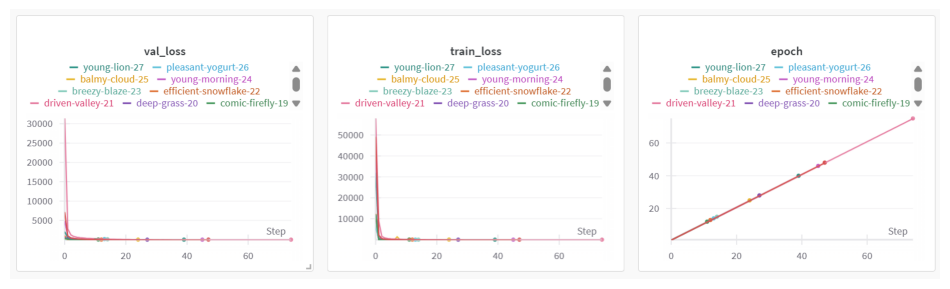

In [90]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [91]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

### Save all the model config

In [92]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


### Select the best model

In [93]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


## Conclusion

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 118\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094


